In [1]:
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.amp import GradScaler, autocast
import os
import random
import shap

In [3]:
import torch
import torch.nn as  nn
import torch.nn.functional as F


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

In [6]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import random

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()
])

dataset = datasets.Imagenette(root='/home/j597s263/scratch/j597s263/Datasets/imagenette', download=False, transform=transform)

random.seed(42) 
indices = list(range(len(dataset)))
random.shuffle(indices)

# Split shuffled indices into training and testing
train_indices = indices[:7568]
test_indices = indices[7568:8522]
attack_indices = indices[8522:]

# Create Subsets
train_data = Subset(dataset, train_indices)
test_data = Subset(dataset, test_indices)
attack_data = Subset(dataset, attack_indices)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)  # Shuffle within batches
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)  # No shuffle for test set
attack_loader = DataLoader(attack_data, batch_size=1, shuffle=False)  # Batch size 1 for mask intersection

# Load the model
model = torch.load('/home/j597s263/scratch/j597s263/Models/Resnet/Base/ResImageBase.mod', weights_only=False, map_location="cuda:0")
model = model.to('cuda')
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


In [9]:
import numpy as np
import matplotlib.pyplot as plt

lime_explanations = np.load('/home/j597s263/scratch/j597s263/Datasets/Explanation_values/Resnet/LimeImg.npy', allow_pickle=True)

print(f"Number of explanations: {len(lime_explanations)}")
print(f"Example explanation: {lime_explanations[0]}")

Number of explanations: 947
Example explanation: {'index': 0, 'label': 2, 'mask': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])}


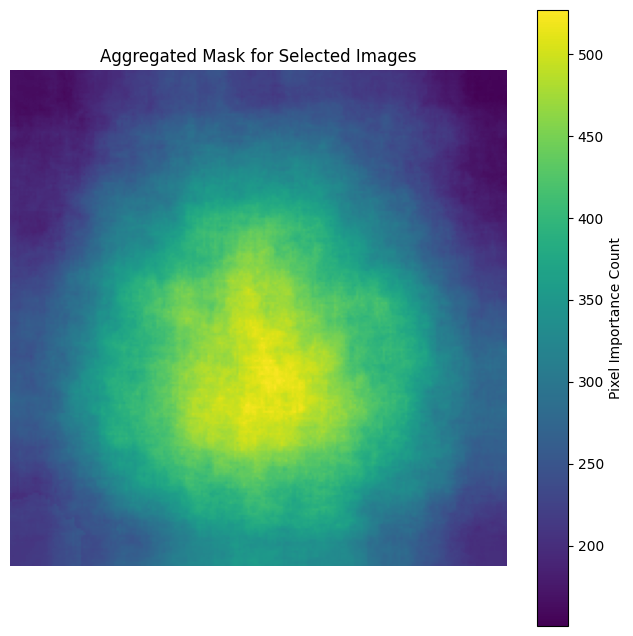

Aggregated Mask Summary:
Shape: (224, 224)
Unique Values: [151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276
 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312
 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330
 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348
 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366
 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 3

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Indices of the selected images
selected_indices = list(range(len(lime_explanations)))  

# Initialize an empty array for aggregation
aggregated_mask = np.zeros_like(lime_explanations[0]['mask'], dtype=int)

# Sum the masks for the selected indices
for i in selected_indices:
    explanation = lime_explanations[i]
    mask = explanation['mask']  # Get the mask for the explanation
    aggregated_mask += mask  # Add the mask to the aggregated array

# Visualize the aggregated mask
plt.figure(figsize=(8, 8))
plt.imshow(aggregated_mask, cmap='viridis')  # Use a color map to highlight intensity
plt.title("Aggregated Mask for Selected Images")
plt.colorbar(label="Pixel Importance Count")
plt.axis('off')
plt.show()

# Print summary
print("Aggregated Mask Summary:")
print(f"Shape: {aggregated_mask.shape}")
print(f"Unique Values: {np.unique(aggregated_mask)}")


In [11]:
# Flatten the aggregated mask and get the indices of the top 22 values
flattened_mask = aggregated_mask.flatten()
top_22_indices = np.argsort(flattened_mask)[-22:][::-1]  # Indices of top 22 values, sorted in descending order

# Convert flattened indices to 2D coordinates
top_22_coords = np.unravel_index(top_22_indices, aggregated_mask.shape)
top_22_coords = list(zip(top_22_coords[0], top_22_coords[1]))

# Print the top 22 pixel coordinates and their values
print("Top 22 Pixel Locations and Their Values:")
for coord in top_22_coords:
    pixel_value = aggregated_mask[coord]
    print(f"Pixel {coord}: Value {pixel_value}")

Top 22 Pixel Locations and Their Values:
Pixel (np.int64(134), np.int64(115)): Value 527
Pixel (np.int64(143), np.int64(119)): Value 526
Pixel (np.int64(131), np.int64(117)): Value 526
Pixel (np.int64(141), np.int64(115)): Value 525
Pixel (np.int64(140), np.int64(120)): Value 525
Pixel (np.int64(140), np.int64(121)): Value 525
Pixel (np.int64(151), np.int64(106)): Value 524
Pixel (np.int64(143), np.int64(116)): Value 524
Pixel (np.int64(135), np.int64(120)): Value 524
Pixel (np.int64(141), np.int64(121)): Value 524
Pixel (np.int64(151), np.int64(107)): Value 524
Pixel (np.int64(137), np.int64(120)): Value 524
Pixel (np.int64(140), np.int64(123)): Value 523
Pixel (np.int64(131), np.int64(114)): Value 523
Pixel (np.int64(135), np.int64(116)): Value 523
Pixel (np.int64(135), np.int64(119)): Value 523
Pixel (np.int64(136), np.int64(120)): Value 523
Pixel (np.int64(136), np.int64(119)): Value 522
Pixel (np.int64(137), np.int64(113)): Value 522
Pixel (np.int64(154), np.int64(106)): Value 522

In [14]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms

output_dir = "/home/j597s263/scratch/j597s263/Datasets/Attack/ResLimeImg"
os.makedirs(output_dir, exist_ok=True)

# Define the top 22 pixel locations (your output from earlier)
top_22_coords = [
    (134, 115), (143, 119), (131, 117), (141, 115), (140, 120),
    (140, 121), (151, 106), (143, 116), (135, 120), (141, 121),
    (151, 107), (137, 120), (140, 123), (131, 114), (135, 116),
    (135, 119), (136, 120), (136, 119), (137, 113), (154, 106),
    (135, 115), (137, 119)
]

to_pil = transforms.ToPILImage()

for idx, (batch_images, _) in enumerate(attack_loader):
    batch_images = batch_images.clone() 

    for img_idx, image_tensor in enumerate(batch_images):
        for x, y in top_22_coords:
            if 0 <= x < image_tensor.size(1) and 0 <= y < image_tensor.size(2):  
                image_tensor[:, x, y] = 0  

        # Convert tensor to PIL image and save
        pil_image = to_pil(image_tensor)
        output_path = os.path.join(output_dir, f"image_{idx * batch_images.size(0) + img_idx}.png")
        pil_image.save(output_path)

    print(f"Processed batch {idx+1}/{len(attack_loader)}")

print(f"Modified images saved to {output_dir}")

Processed batch 1/947
Processed batch 2/947
Processed batch 3/947
Processed batch 4/947
Processed batch 5/947
Processed batch 6/947
Processed batch 7/947
Processed batch 8/947
Processed batch 9/947
Processed batch 10/947
Processed batch 11/947
Processed batch 12/947
Processed batch 13/947
Processed batch 14/947
Processed batch 15/947
Processed batch 16/947
Processed batch 17/947
Processed batch 18/947
Processed batch 19/947
Processed batch 20/947
Processed batch 21/947
Processed batch 22/947
Processed batch 23/947
Processed batch 24/947
Processed batch 25/947
Processed batch 26/947
Processed batch 27/947
Processed batch 28/947
Processed batch 29/947
Processed batch 30/947
Processed batch 31/947
Processed batch 32/947
Processed batch 33/947
Processed batch 34/947
Processed batch 35/947
Processed batch 36/947
Processed batch 37/947
Processed batch 38/947
Processed batch 39/947
Processed batch 40/947
Processed batch 41/947
Processed batch 42/947
Processed batch 43/947
Processed batch 44/9